In [371]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PF import *
from Position import *
from LidarSim import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


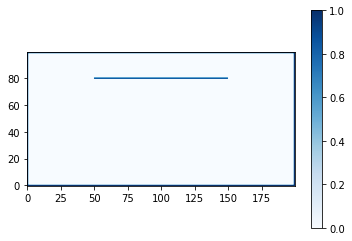

In [372]:
SIZE_X = 200
SIZE_Y = 100

# init a map, and draw some arbitrary shapes
MAP = np.zeros([SIZE_X, SIZE_Y])
MAP[:,0] = 1
MAP[:,99] = 1
MAP[0,:] = 1
MAP[199,:] = 1
MAP[50:150,80] = 1
plt.imshow(MAP.T, origin='lower', cmap='Blues')
plt.colorbar()
plt.show()

true_position = Position(50, 10, 1.5)

In [373]:
def plot_pf_img(pf):
    # DEPRECATED
    img = np.zeros([SIZE_Y, SIZE_X])
    for particle in pf.particles:
        img[int(particle.y)][int(particle.x)] = particle.weight

    plt.imshow(img, cmap='gray')
    plt.colorbar()

def plot_pf_qvr(particles=None, map=None, true_position=None, best_guess=None):
    if particles is not None:
        for particle in particles:
            # print(particle.x, particle.y, particle.theta, particle.weight)
            plt.quiver(particle.x, particle.y, particle.weight*math.cos(particle.theta), particle.weight*math.sin(particle.theta), width=0.005, scale=20)
    if map is not None:
        plt.imshow(map.T, origin='lower', cmap='Blues')
        plt.colorbar()
    if true_position is not None:
        plt.quiver(true_position.x, true_position.y, math.cos(true_position.theta), math.sin(true_position.theta), width=0.005, scale=20, color='r')
    if best_guess is not None:
        plt.quiver(best_guess.x, best_guess.y, math.cos(best_guess.theta), math.sin(best_guess.theta), width=0.005, scale=20, color='g')
    plt.ylim(0, SIZE_Y)
    plt.xlim(0, SIZE_X)
    plt.show()


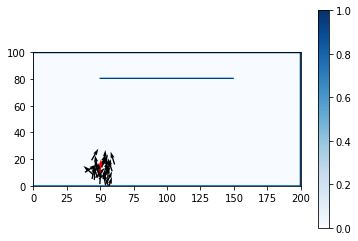

In [374]:
# Init filter
pf = PF(position=true_position, map=MAP, particle_cnt=30, pos_sd=5, rot_sd=0.35)
plot_pf_qvr(pf.particles, map=MAP, true_position=true_position)

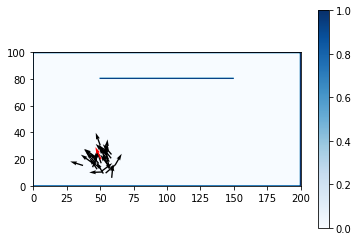

In [375]:
# assume some movement forward from odometry
dx = 10
dtheta = .5
pf.propagate_odom(dx, dtheta, 2, 0.3)
update_pos(true_position, dx, dtheta)
plot_pf_qvr(pf.particles, map=MAP, true_position=true_position)

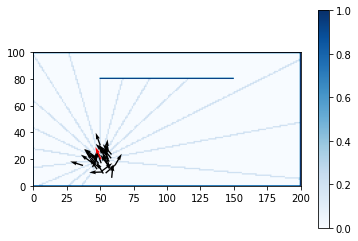

In [376]:
# sample lidar
observed_lidar = LidarSim()
lidar_map, observed_lidar_data = observed_lidar.getRays(true_position, MAP)
plot_pf_qvr(particles=pf.particles, map=lidar_map, true_position=true_position)

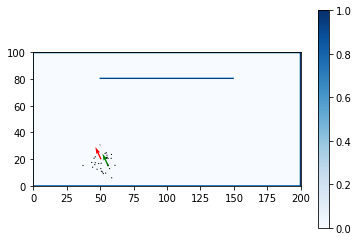

In [377]:
# update weights based of estimated lidar from each particle
pf.update_weights_inverse_dist(observed_lidar_data)
pf.normalize_weights()
pf.update_best_guess()
plot_pf_qvr(pf.particles, map=MAP, true_position=true_position, best_guess=pf.best_guess)

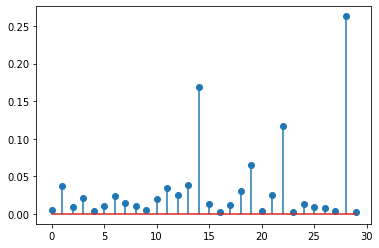

In [378]:
# check distribution of weights
ns = []
ws = []
for n in range(pf.particle_cnt):
    ns.append(n)
    ws.append(pf.particles[n].weight)

plt.stem(ns, ws)
plt.show()

[28, 28, 28, 1, 28, 21, 16, 24, 19, 14, 14, 14, 28, 19, 10, 14, 19, 22, 11, 1, 28, 11, 14, 12]


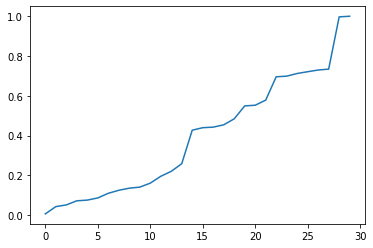

In [379]:
# resample points
cdf, samps = pf.resample(.8)
print(samps)
plt.plot(cdf)
plt.show()

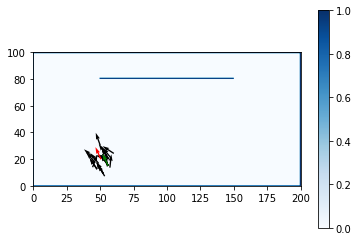

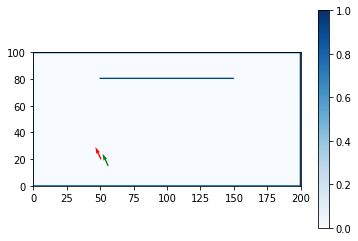

In [380]:
# plot new particle field
plot_pf_qvr(pf.particles, map=MAP, true_position=true_position, best_guess=pf.best_guess)

#plot current and guess
plot_pf_qvr(particles=None, map=MAP, true_position=true_position, best_guess=pf.best_guess)